# **AAGE - Práctica 2: Aprendizaje federado y continuo**

- Andrés Lires Saborido - andres.lires@udc.es

- Ángel Vilariño García - angel.vilarino.garcia@udc.es

## Parte II: Aprendizaje Continuo con River

In [31]:
from river import datasets, compose, preprocessing, feature_extraction, tree, naive_bayes, drift, metrics, evaluate, forest
from river.stream import iter_pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#### 1. De *batch* a *streaming*
##### 1.1 Carga de datos y preprocesamiento

In [13]:
# Carga del dataset Electricity
dataset = datasets.Elec2()

# Mostrar el tamaño del dataset
print(f"Tamaño del dataset Electricity: {len(list(dataset))} ejemplos")
print(f"Número de características: {len(next(iter(dataset))[0])}")

# Mostrar primeros 5 ejemplos
print("\nPrimeros 5 ejemplos del dataset:")
for i, (x, y) in enumerate(dataset):
    if i >= 5:
        break
    print(f"Ejemplo {i+1}: {x} -> {y}")

# Convertir a formato pandas para scikit-learn
X_list = []
y_list = []
for x, y in dataset:
    X_list.append(list(x.values()))
    y_list.append(y)

X_array = np.array(X_list)
y_array = np.array(y_list)

Tamaño del dataset Electricity: 45312 ejemplos
Número de características: 8

Primeros 5 ejemplos del dataset:
Ejemplo 1: {'date': 0.0, 'day': 2, 'period': 0.0, 'nswprice': 0.056443, 'nswdemand': 0.439155, 'vicprice': 0.003467, 'vicdemand': 0.422915, 'transfer': 0.414912} -> True
Ejemplo 2: {'date': 0.0, 'day': 2, 'period': 0.021277, 'nswprice': 0.051699, 'nswdemand': 0.415055, 'vicprice': 0.003467, 'vicdemand': 0.422915, 'transfer': 0.414912} -> True
Ejemplo 3: {'date': 0.0, 'day': 2, 'period': 0.042553, 'nswprice': 0.051489, 'nswdemand': 0.385004, 'vicprice': 0.003467, 'vicdemand': 0.422915, 'transfer': 0.414912} -> True
Ejemplo 4: {'date': 0.0, 'day': 2, 'period': 0.06383, 'nswprice': 0.045485, 'nswdemand': 0.314639, 'vicprice': 0.003467, 'vicdemand': 0.422915, 'transfer': 0.414912} -> True
Ejemplo 5: {'date': 0.0, 'day': 2, 'period': 0.085106, 'nswprice': 0.042482, 'nswdemand': 0.251116, 'vicprice': 0.003467, 'vicdemand': 0.422915, 'transfer': 0.414912} -> False


##### 1.2 Entrenamiento de GaussianNB con Scikit-learn (modo tradicional)

In [ ]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split( X_array, y_array, test_size=0.3, random_state=42, shuffle=False)

# Entrenamiento
sklearn_gnb = GaussianNB()
sklearn_gnb.fit(X_train, y_train)

# Evaluar
y_pred_sklearn = sklearn_gnb.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f"Accuracy Scikit-learn GaussianNB: {accuracy_sklearn}")

Accuracy Scikit-learn GaussianNB: 0.7539


##### 1.3 Entrenamiento incremental de GaussianNB con River

In [8]:
# Entrenamiento incremental de GaussianNB con River
river_gnb = naive_bayes.GaussianNB()

# Reinicializar el dataset
dataset = datasets.Elec2()

# Evaluación progresiva
acc_metric = metrics.Accuracy()
river_accuracies = []

print("Evaluación progresiva River GaussianNB:")
for i, (x, y) in enumerate(dataset):
    y_pred = river_gnb.predict_one(x)
    
    if y_pred is not None:
        acc_metric.update(y, y_pred)
        river_accuracies.append(acc_metric.get())
    
    river_gnb.learn_one(x, y)
    
    if i % 10000 == 0 and i > 0:
        print(f"Ejemplo {i}: Accuracy = {acc_metric.get()}")

print(f"Accuracy final River GaussianNB: {acc_metric.get()}")

Evaluación progresiva River GaussianNB:
Ejemplo 10000: Accuracy = 0.7929
Ejemplo 20000: Accuracy = 0.76295
Ejemplo 30000: Accuracy = 0.7319333333333333
Ejemplo 40000: Accuracy = 0.722075
Accuracy final River GaussianNB: 0.7287413652314008


##### 1.4 Comparación de rendimiento

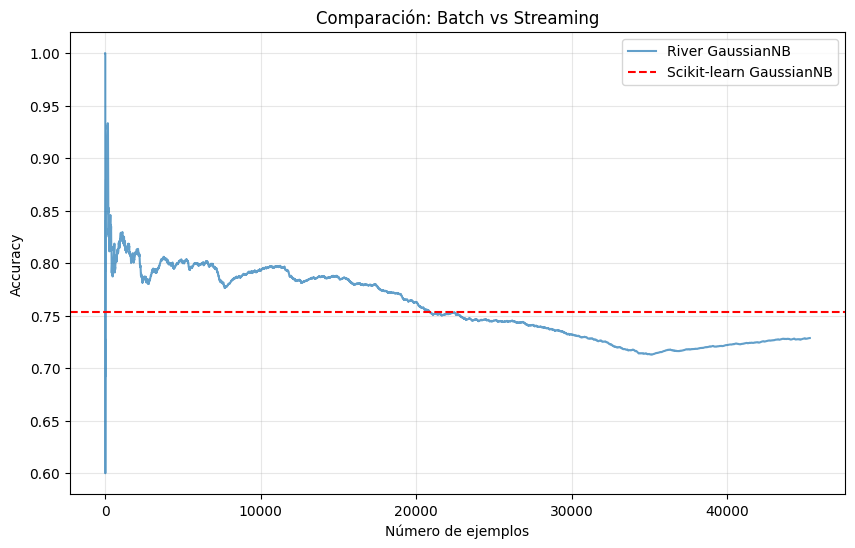

In [ ]:
# Comparación de rendimiento

# Gráfico de evolución del accuracy en streaming
plt.figure(figsize=(10, 6))
plt.plot(river_accuracies, label='River GaussianNB', alpha=0.7)
plt.axhline(y=accuracy_sklearn, color='r', linestyle='--', label='Scikit-learn GaussianNB')
plt.xlabel('Número de ejemplos')
plt.ylabel('Accuracy')
plt.title('Comparación: Batch vs Streaming')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 2. Manejo de *concept drift*

In [18]:
# Reinicializar dataset
dataset = datasets.Elec2()

# Detector de drift ADWIN
adwin_detector = drift.ADWIN()
# Modelo GaussianNB con manejo de drift
model_with_drift = naive_bayes.GaussianNB()

# Inicialización de métricas
acc_metric_drift = metrics.Accuracy()
drift_detections = []
accuracies_with_drift = []

print("Manejo de drift con ADWIN:\n")
for i, (x, y) in enumerate(dataset):
    y_pred = model_with_drift.predict_one(x)
    
    if y_pred is not None:
        acc_metric_drift.update(y, y_pred)
        accuracies_with_drift.append(acc_metric_drift.get())
        
        # Actualizar detector de drift con el error
        error = 1 if y != y_pred else 0
        adwin_detector.update(error)
        
        # Detectar cambio conceptual
        if adwin_detector.drift_detected:
            drift_detections.append(i)
            print(f"Drift detectado en ejemplo {i} - Accuracy actual: {acc_metric_drift.get()}")
            
            # Estrategia: reinicializar modelo completamente
            model_with_drift = naive_bayes.GaussianNB()
    
    model_with_drift.learn_one(x, y)

print(f"\nTotal de drifts detectados: {len(drift_detections)}")
print(f"Posiciones de drift: {drift_detections[:5]}...")  # Mostrar solo los primeros 5

Manejo de drift con ADWIN:

Drift detectado en ejemplo 224 - Accuracy actual: 0.8258928571428571
Drift detectado en ejemplo 1664 - Accuracy actual: 0.8100961538461539
Drift detectado en ejemplo 2240 - Accuracy actual: 0.8
Drift detectado en ejemplo 2432 - Accuracy actual: 0.8030427631578947
Drift detectado en ejemplo 4384 - Accuracy actual: 0.8191149635036497
Drift detectado en ejemplo 5088 - Accuracy actual: 0.8223270440251572
Drift detectado en ejemplo 7232 - Accuracy actual: 0.8181692477876106
Drift detectado en ejemplo 9312 - Accuracy actual: 0.8272121993127147
Drift detectado en ejemplo 11584 - Accuracy actual: 0.8223411602209945
Drift detectado en ejemplo 11904 - Accuracy actual: 0.821236559139785
Drift detectado en ejemplo 12672 - Accuracy actual: 0.818655303030303
Drift detectado en ejemplo 14144 - Accuracy actual: 0.8221153846153846
Drift detectado en ejemplo 14848 - Accuracy actual: 0.8235452586206896
Drift detectado en ejemplo 15264 - Accuracy actual: 0.8240303983228512
Drif

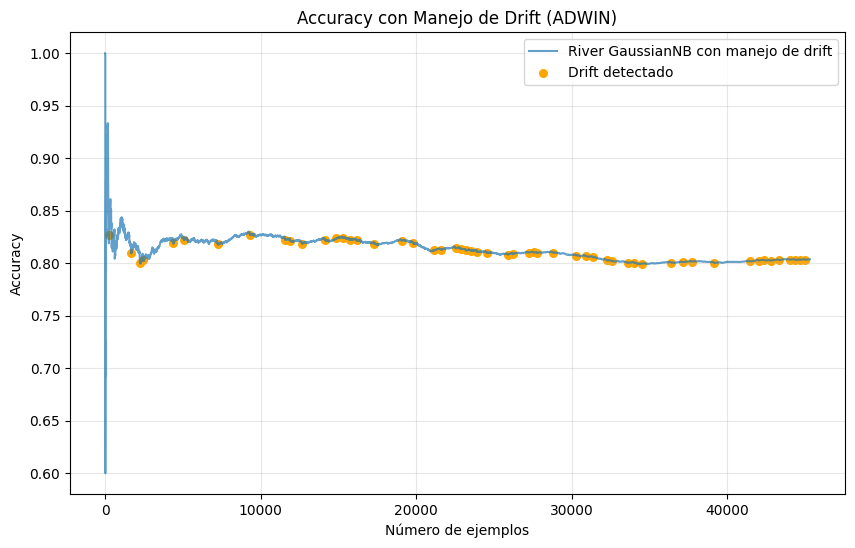

In [23]:
# Graficamos el accuracy con manejo de drift, mostrando los puntos de drift
plt.figure(figsize=(10, 6))
plt.plot(accuracies_with_drift, label='River GaussianNB con manejo de drift', alpha=0.7)
for drift_point in drift_detections:
   # Marcamos un punto en el gráfico donde se detectó drift
   plt.scatter(drift_point, accuracies_with_drift[drift_point], color='orange', s=30, label='Drift detectado' if drift_point == drift_detections[0] else "")

plt.xlabel('Número de ejemplos')
plt.ylabel('Accuracy')
plt.title('Accuracy con Manejo de Drift (ADWIN)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Hoeffding Adaptive Tree (HAT)

# Reinicializar dataset
dataset = datasets.Elec2()

# Pipeline con HAT
hat_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    feature_extraction.RBFSampler(seed=42),
    tree.HoeffdingAdaptiveTreeClassifier(seed=42)
)

acc_hat = metrics.Accuracy()
hat_accuracies = []

print("Entrenando Hoeffding Adaptive Tree:")
for i, (x, y) in enumerate(dataset):
    y_pred = hat_model.predict_one(x)
    
    if y_pred is not None:
        acc_hat.update(y, y_pred)
        hat_accuracies.append(acc_hat.get())
    
    hat_model.learn_one(x, y)
    
    if i % 10000 == 0 and i > 0:
        print(f"Ejemplo {i}: Accuracy = {acc_hat.get()}")

print(f"Accuracy final HAT: {acc_hat.get()}")

Entrenando Hoeffding Adaptive Tree:
Ejemplo 10000: Accuracy = 0.8346
Ejemplo 20000: Accuracy = 0.8304
Ejemplo 30000: Accuracy = 0.8182
Ejemplo 40000: Accuracy = 0.8103
Accuracy final HAT: 0.8150


In [32]:
# Adaptive Random Forest (ARF)

# Reinicializar dataset
dataset = datasets.Elec2()

# Pipeline con ARF
arf_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    forest.ARFClassifier(seed=42)
)

acc_arf = metrics.Accuracy()
arf_accuracies = []

print("Entrenando Adaptive Random Forest:")
for i, (x, y) in enumerate(dataset):
    y_pred = arf_model.predict_one(x)
    
    if y_pred is not None:
        acc_arf.update(y, y_pred)
        arf_accuracies.append(acc_arf.get())
    
    arf_model.learn_one(x, y)
    
    if i % 10000 == 0 and i > 0:
        print(f"Ejemplo {i}: Accuracy = {acc_arf.get()}")

print(f"Accuracy final ARF: {acc_arf.get()}")

Entrenando Adaptive Random Forest:
Ejemplo 10000: Accuracy = 0.9083
Ejemplo 20000: Accuracy = 0.9089
Ejemplo 30000: Accuracy = 0.8999666666666667
Ejemplo 40000: Accuracy = 0.89395
Accuracy final ARF: 0.8943965041601377


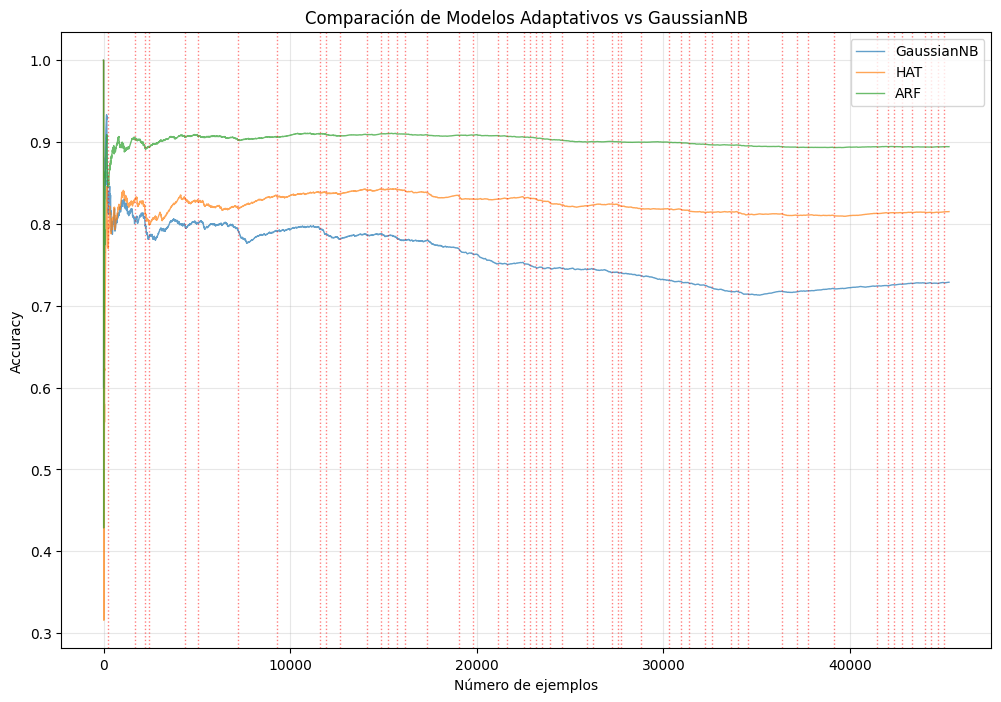

In [37]:
# Gráfico comparativo
plt.figure(figsize=(12, 8))

# Asegurarnos de que todas las listas tengan la misma longitud
min_length = min(len(river_accuracies), len(hat_accuracies), len(arf_accuracies))

plt.plot(river_accuracies[:min_length], label='GaussianNB', alpha=0.7, linewidth=1)
plt.plot(hat_accuracies[:min_length], label='HAT', alpha=0.7, linewidth=1)
plt.plot(arf_accuracies[:min_length], label='ARF', alpha=0.7, linewidth=1)

# Marcar detecciones de drift en todas las gráficas
for drift_pos in drift_detections:
    if drift_pos < min_length:
        plt.axvline(x=drift_pos, color='red', linestyle=':', alpha=0.5, linewidth=1)

plt.xlabel('Número de ejemplos')
plt.ylabel('Accuracy')
plt.title('Comparación de Modelos Adaptativos vs GaussianNB')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()